In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq
# import bvbq.gp
# import bvbq.bvi
# import bvbq.distributions

In [7]:
ndim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

In [10]:
def test_function(params):
    x = params['x']
    return jnp.sum(x**2)

learning_rate = 1e-1
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",learning_rate)
optwrapper.init({'x':jnp.ones(2)},jax.value_and_grad(test_function))
for i in range(50):
    value,_ = optwrapper.step()
#     print(value)
print(optwrapper.params)

{'x': DeviceArray([-0.00481431, -0.00481431], dtype=float32)}


If tensor has more than 2 dimensions, only diagonal of covariance is returned


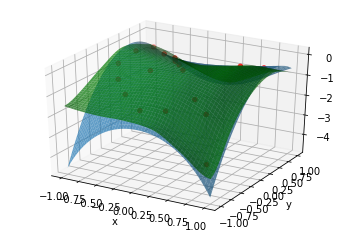

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

xys = (2*(sobol_seq.i4_sobol_generate(2,20)-0.5)) #[-1,1] cube
zs = exponential_quartic(xys)
ax.scatter(xys[:,0],xys[:,1],zs,color='red')
ax.set_xlabel('x');
ax.set_ylabel('y');

gp = bvbq.gp.SimpleGP(2,kind='smatern32',noise=0)
gp.set_data(xys,zs,empirical_params=True)
gp.optimize_params()
Zreg = gp.predict(np.stack([X,Y],axis=-1))[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [13]:
x = np.random.rand(5,2)

distrib = bvbq.distributions.DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
print(distrib.sample(100).mean(axis=0))
print(distrib.logprob(x))
print(distrib.sample(101).mean(axis=0))

[-0.99044454 -1.0060383 ]
[-301.80716 -158.27931 -294.80444 -237.84756 -310.4032 ]
[-0.9890031 -1.015915 ]


In [14]:
distrib.sample(1000)

DeviceArray([[-0.8505697, -1.2835306],
             [-1.0557429, -0.7975483],
             [-1.2355732, -0.735934 ],
             ...,
             [-1.1745535, -1.3255067],
             [-0.7992455, -0.7005598],
             [-1.5006654, -0.9399502]], dtype=float32)

In [15]:
mixdistrib = distrib.make_mixture()
mixdistrib.add_component(jnp.ones(2),0.1*jnp.ones(2),0.1)
mixdistrib.add_component(2*jnp.ones(2),0.1*jnp.ones(2),0.1)
print(mixdistrib.logprob(x))
print(mixdistrib.sample(100).mean())
print(mixdistrib.sample(101).mean())

[-2.702716  -7.656293  -3.2022219 -6.9514666 -3.0097933]
-0.37293068
-0.6136273


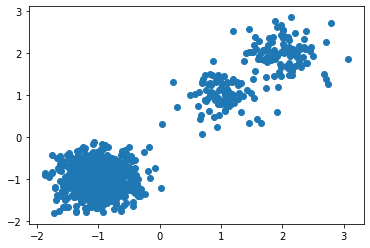

In [16]:
x = mixdistrib.sample(1000)
plt.scatter(x[:,0],x[:,1])

In [12]:
@jax.jit
def logbound(logx,logdelta):
    clipx = jnp.clip(logx,logdelta,None)
    boundx = clipx + jnp.log(jnp.exp(logx-clipx) + \
                             jnp.exp(logdelta-clipx))
    return boundx

In [19]:
bvbq.bvi

<module 'bvbq.bvi' from '../bvbq/bvi.py'>

In [23]:
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

def objective_function_relbo_2(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = bvbq.distributions.DiagonalNormalDistribution(mean,var)
    logprob = functools.partial(logprob_t,nu=1)
    res = -bvbq.bvi.relbo(logprob,mixdistrib,newcomp,1000,reg=1e0,logdelta=-5)
    return res

def objective_function_gradboost_2(weight,distrib,mixdistrib):
    logprob = functools.partial(logprob_t,nu=1000)
    res = -bvbq.bvi.boosted_elbo(logprob,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(1),'rawvar':0.1*jnp.zeros(1)}
distrib = bvbq.distributions.DiagonalNormalDistribution(5*jnp.ones(1),jnp.ones(1))
mixdistrib = distrib.make_mixture()
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo_2,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost_2)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(-4.66147, dtype=float32), {'mean': DeviceArray([0.05045595], dtype=float32), 'rawvar': DeviceArray([-0.12207514], dtype=float32)})
(DeviceArray(12.308316, dtype=float32), DeviceArray(0.00424576, dtype=float32))


In [26]:
alpha_boost = 1e0
maxiter_boost = 100
alpha_relbo = 3*1e-1
maxiter_relbo = 100
maxiter = 5
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha_relbo)
for k in range(maxiter):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(1,)),
              'rawvar':3*jax.random.normal(mixdistrib.split_key(),(1,))}
    optwrapper.init(params,func_and_grad_relbo)
    for i in range(maxiter_relbo):
        value,grads = optwrapper.step(mixdistrib)
        params = optwrapper.params
#         print(value,params['mean'],jax.nn.softplus(params['rawvar']))
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)
    weight = 0.01
    print('--')
    print(mean,var)
    for i in range(maxiter_boost):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-2:
            break
#         print(weight,res,gradweight)
    mixdistrib.add_component(mean,var,weight)
    print(k,mean,var,weight)
    print('--')

--
[3.8478475] [8.775109]
0 [3.8478475] [8.775109] 1e-04
--
--
[2.8661525] [15.713153]
1 [2.8661525] [15.713153] 1e-04
--
--
[2.5462508] [18.28128]


KeyboardInterrupt: 

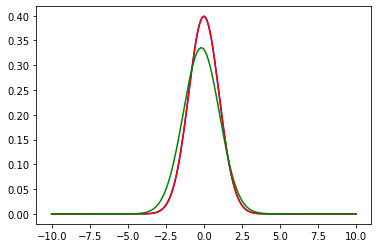

In [27]:
x = np.linspace(-10,10,201)
y = logprob_t(x,1000)
y2 = -0.5*x**2 - 0.5*np.log(2*np.pi)
yvi = mixdistrib.logprob(x.reshape(-1,1)).flatten()
plt.plot(x,np.exp(y),'b')
plt.plot(x,np.exp(y2),'r')
plt.plot(x,np.exp(yvi),'g')

In [28]:
mixdistrib.weights.sum()

DeviceArray(0.99999994, dtype=float32)

In [29]:
mixdistrib.add_component(np.zeros(1),np.ones(1),0.5)

In [30]:
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

def objective_function_relbo_2(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = bvbq.distributions.DiagonalNormalDistribution(mean,var)
    logprob = functools.partial(logprob_t,nu=1)
    res = -bvbq.bvi.relbo(logprob,mixdistrib,newcomp,1000,reg=1e0,logdelta=-5)
    return res

def objective_function_gradboost_2(weight,distrib,mixdistrib):
#     logprob = functools.partial(logprob_t,nu=1000)
    logprob = exponential_quartic
    res = -bvbq.bvi.boosted_elbo(logprob,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(2),'rawvar':0.1*jnp.zeros(2)}
distrib = bvbq.distributions.DiagonalNormalDistribution(jnp.zeros(2),jnp.ones(2))
mixdistrib = distrib.make_mixture()
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo_2,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost_2)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(-3.3161716, dtype=float32), {'mean': DeviceArray([-0.0060608 , -0.00559549], dtype=float32), 'rawvar': DeviceArray([-0.45201987, -0.45770144], dtype=float32)})
(DeviceArray(0.835276, dtype=float32), DeviceArray(-0.02615952, dtype=float32))


In [36]:
alpha_boost = 1e0
maxiter_boost = 100
alpha_relbo = 1e-3
maxiter_relbo = 100
maxiter = 10
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha_relbo)
for k in range(maxiter):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(2,)),
              'rawvar':3*jax.random.normal(mixdistrib.split_key(),(2,))}
    optwrapper.init(params,func_and_grad_relbo)
    for i in range(maxiter_relbo):
        value,grads = optwrapper.step(mixdistrib)
        params = optwrapper.params
#         print(value,params['mean'],jax.nn.softplus(params['rawvar']))
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
#     mean,var = jnp.zeros(1),jnp.ones(1)
    distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)
    weight = 1e-12
    print('--')
    print(mean,var)
    for i in range(maxiter_boost):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight = jnp.clip(weight,1e-12,1-1e12)
        if abs(gradweight) < 1e-2:
            break
        print(weight,res,gradweight)
    mixdistrib.add_component(mean,var,weight)
    print(k,mean,var,weight)
    print('--')

--
[ 1.0887313  -0.76624817] [0.00164976 0.3564104 ]
-1000000000000.0 1.0079429 0.77146375
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan n

nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
6 [nan nan] [nan nan] nan
--
--
[nan nan] [nan nan]
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
